In [1]:
# import libraries
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the data set
sonets = open('Shakspeare.txt','r').read().lower().replace('\n',' ').split('  ')

In [3]:
# create a word list
words = list(set(' '.join(sonets).split(' ')))

In [27]:
# create dictionaires
wtoi = {w:i+1 for i,w in enumerate(words)}
wtoi['...'] = 0
itow = {i:w for w,i in wtoi.items()}

In [60]:
# define hyperparameters
blockSize = 5             # input window size
batchSize = 50            # mini-batch size
neuronCount = 100         # hidden layer neuron count
embedSize = 10            # embedding size
wordCount = len(words)+1  # number of words

In [61]:
# build the data set
def build_dataset(sonets):

  blockSize = 5
  X,Y = [],[]

  for sonet in sonets:

    context = [0]*blockSize

    for word in sonet.split(' ') + ['...']:
      ix = wtoi[word]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

# define train dev and test sets
import random
random.seed(42)
random.shuffle(sonets)
n1 = int(0.8*len(sonets))
n2 = int(0.9*len(sonets))

Xtr, Ytr = build_dataset(sonets[:n1])
Xdev, Ydev = build_dataset(sonets[n1:n2])
Xte, Yte = build_dataset(sonets[n2:])

In [29]:
# visulaize first 10 training examples
for i in range(10):
  print(' '.join(itow[ix.item()] for ix in Xtr[i]), '--->',itow[Ytr[i].item()])

... ... ... ... ... ---> shall
... ... ... ... shall ---> i
... ... ... shall i ---> compare
... ... shall i compare ---> thee
... shall i compare thee ---> to
shall i compare thee to ---> a
i compare thee to a ---> summer's
compare thee to a summer's ---> day?
thee to a summer's day? ---> thou
to a summer's day? thou ---> art


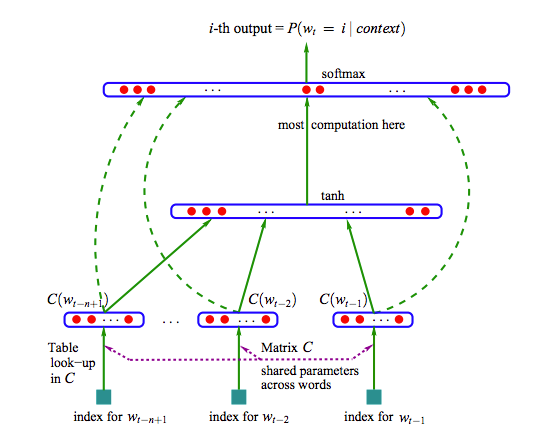

In [62]:
# We have used Bengio et al. 2003
# initialize the parameters
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((wordCount,embedSize),                 generator = g)
W1 = torch.randn((embedSize * blockSize ,neuronCount), generator = g)
b1 = torch.randn(neuronCount,                          generator = g)
W2 = torch.randn((neuronCount, wordCount),             generator = g)
b2 = torch.randn(wordCount,                            generator = g)

parameters = [C, W1, b1 ,W2, b2]

for p in parameters:
  p.requires_grad = True

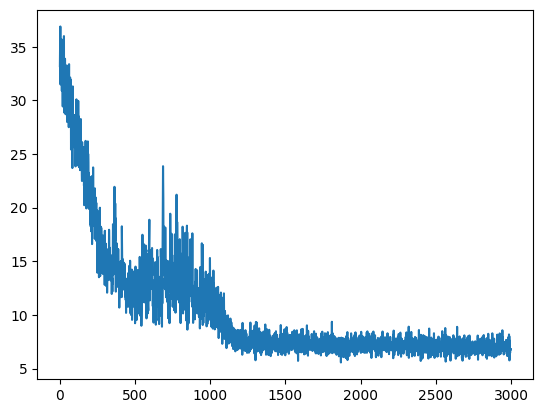

In [63]:
# train the model iteratively

losses = []
for i in range(3000):

  #mini batch construct
  ix = torch.randint(0,Xtr.shape[0],(batchSize,))

  #forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,embedSize * blockSize) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  losses.append(loss.item())

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 1 if i<1000 else 0.1
  for p in parameters:
    p.data += -lr*p.grad

plt.plot(losses)

In [64]:
# check the train and dev losses
emb = C[Xtr]
h = torch.tanh(emb.view(-1,embedSize * blockSize) @ W1 + b1)
logits = h @ W2 + b2
trainLoss = F.cross_entropy(logits, Ytr)


emb = C[Xdev]
h = torch.tanh(emb.view(-1,embedSize * blockSize) @ W1 + b1)
logits = h @ W2 + b2
devLoss = F.cross_entropy(logits, Ydev)

print(f"Train loss: {trainLoss: .4f}\nDev loss: {devLoss: .4f}")

Train loss:  7.0161
Dev loss:  8.3224


In [68]:
# sample from the model
for i in range(3):
  out = []
  context = [0]*blockSize
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(-1,embedSize * blockSize) @ W1 + b1)
    logits = h @ W2 + b2
    probs = torch.softmax(logits, dim = 1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(' '.join(itow[i] for i in  out))
  print('\n\n')

thine untrue. air creation best teach repair exchanged, wilfully benefit faults, beside awake, canker beside. true? need, to virtue for gentle shun air ...



and level that beauty any year i he shines and wish, gazeth, and pleasure roses nor in bestow'st, by love's ...



to-morrow  thy leaves seal, require. is i man, faring the beauty thoughts tattered forgot that simple earth i praised groans of might, beauty return but be nor my chiding filled beauteous my wonder 'will', poor, addition my seest that pupil the love it do your side, all is with the there coward ...



